In [11]:
%matplotlib inline

import pandas as pd
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

In [12]:
def systematic_regular(no_of_samples, x, y):
    # Calculate the dimensions of the regular grid
    rows = int(np.sqrt(no_of_samples))
    cols = int(np.ceil(no_of_samples / rows))

    # Calculate the padding to ensure points are equally spaced
    padding_x = (x - (rows - 1)) // rows
    padding_y = (y - (cols - 1)) // cols

    # Initialize points list
    points = []

    # Select equally spaced points with padding
    for i in range(rows):
        for j in range(cols):
            points.append((int((i * (padding_x + 1)) + ((padding_x + 1)/2)), int((j * (padding_y + 1) + ((padding_y + 1)/2)))))

    return points[:no_of_samples]

def wageningen_w():
    return [(50, 50), (50, 150), (50, 250), (50, 350), (125, 150), (175, 250), (275, 150), (225, 250), (350, 50), (350, 150), (350, 250), (350, 350)]


def retrieve_ids_per_sample_von_neumann(points, data, r):
    samples =  [ [] for _ in range(len(points)) ]
    for ind, row in data.iterrows():
        for index, point in enumerate(points):
            x1, y1 = point
            x2 = row.x
            y2 = row.y

            if (abs(x1 - x2) % 400 + abs(y1 - y2) % 400) <= r:
                samples[index].append(ind)
    return samples

def pearson_cooccurrence(abundance_data, threshold=0):
    # Initialize a graph
    G = nx.Graph()
    G.add_nodes_from(range(9))

    # Calculate the Pearson correlation coefficient matrix
    pearson_matrix = np.corrcoef(abundance_data, rowvar=False)
    
    pearson_matrix[np.isnan(pearson_matrix)] = 0

    # Get the number of entities
    num_entities = len(abundance_data[0])

    # Iterate through the Pearson correlation matrix to create co-occurrence edges
    for i in range(num_entities):
        for j in range(i + 1, num_entities):
            # Check if the correlation coefficient exceeds the threshold
            if (pearson_matrix[i][j] > threshold):
                G.add_edge(i, j, weight=pearson_matrix[i][j])

    return G, pearson_matrix

def manhattan_neighborhood_matrix(df):
    # Initialize the grid dictionary
    grid = {}
    
    # Populate the grid with entity locations and types
    for _, row in df.iterrows():
        t, x, y = row['type'], row['x'], row['y']
        grid[(x, y)] = t
    
    # Define Manhattan neighbors offsets (distance 1 in 3D)
    neighbors_offsets = [
        (dx, dy) 
        for dx in (-1, 0, 1) 
        for dy in (-1, 0, 1) 
        if dx != 0 or dy != 0
    ]
    
    # Initialize the 9x9 matrix
    matrix = np.zeros((9, 9), dtype=int)
    
    # Calculate type counts in the neighborhood
    for (x, y), t in grid.items():
        for dx, dy in neighbors_offsets:
            neighbor_pos = ((x + dx)%400, (y + dy)%400)
            if neighbor_pos in grid:
                neighbor_type = grid[neighbor_pos]
                matrix[int(t)][int(neighbor_type)] += 1
    
    return matrix

In [13]:
filenames = ['random_1', 'random_2', 'random_3', 'random_4', 'random_5', 'random_6', 'clustered_1', 'clustered_2', 'clustered_3', 'clustered_4', 'clustered_5', 'clustered_6']
path = "../blossom/hpc/outputs/"
rs = [1, 2, 3, 4, 5]
init_locs = ['R1', 'R1', 'R1', 'R1', 'R1', 'R1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1']
init_seed  = [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]
# TBD
sample_times = [79, 91, 94, 129, 131, 82, 94, 76, 76, 79, 76, 120, 90, 105, 83, 132]

x_max = 400
y_max = 400

no_of_samples = 16

selected_points_reg = systematic_regular(no_of_samples, x_max, y_max)
selected_points_w = wageningen_w()

In [14]:
sample_counts_w = pd.DataFrame(columns=['filename', 'init_locs', 'seed', 'diameter','sample_id', '0', '1', '2', '3', '4', '5', '6', '7', '8'])

for idx, filename in enumerate(filenames):  
    df = pd.read_csv(path + filename + ".csv")
    data = df[df["tick"] == sample_times[idx]]
    data = data.reset_index(drop=True)
    
    for r in rs:
        samples_w = retrieve_ids_per_sample_von_neumann(selected_points_w, data, r)
    
        sample_site_counts_w = []
        for i, sample in enumerate(samples_w):
            df2 = data.iloc[sample]
            counts = df2['type'].value_counts().reindex(range(len(df["type"].unique())), fill_value=0)
            sample_counts_w = pd.concat([sample_counts_w, pd.DataFrame({'filename': [filename], 'init_locs': [init_locs[idx]], 'seed': [init_seed[idx]], 'diameter': [r], 'sample_id': [i], '0': [counts[0]], '1': [counts[1]], '2': [counts[2]], '3': [counts[3]], '4': [counts[4]], '5': [counts[5]], '6': [counts[6]], '7': [counts[7]], '8': [counts[8]]})])

sample_counts_w.to_csv('sample_counts_w.csv', index=False)            

In [6]:

sample_counts_reg = pd.DataFrame(columns=['filename', 'init_locs', 'seed', 'diameter','sample_id', '0', '1', '2', '3', '4', '5', '6', '7', '8'])

for idx, filename in enumerate(filenames):  
    df = pd.read_csv(path + filename + ".csv")
    data = df[df["tick"] == sample_times[idx]]
    data = data.reset_index(drop=True)
    
    for r in rs:
        samples_reg = retrieve_ids_per_sample_von_neumann(selected_points_reg, data, r)

        sample_site_counts_reg = []
        for i, sample in enumerate(samples_reg):
            df2 = data.iloc[sample]
            counts = df2['type'].value_counts().reindex(range(len(df["type"].unique())), fill_value=0)
            sample_counts_reg = pd.concat([sample_counts_reg, pd.DataFrame({'filename': [filename], 'init_locs': [init_locs[idx]], 'seed': [init_seed[idx]], 'diameter': [r], 'sample_id': [i], '0': [counts[0]], '1': [counts[1]], '2': [counts[2]], '3': [counts[3]], '4': [counts[4]], '5': [counts[5]], '6': [counts[6]], '7': [counts[7]], '8': [counts[8]]})])
            
sample_counts_reg.to_csv('sample_counts_reg.csv', index=False)

In [8]:
neighborhood_counts = pd.DataFrame(columns=['filename', 'init_locs', 'seed', 'diameter', 'sampling_method', '0', '1', '2', '3', '4', '5', '6', '7', '8'])

for idx, filename in enumerate(filenames):  
    df = pd.read_csv(path + filename + ".csv")
    data = df[df["tick"] == sample_times[idx]]
    data = data.reset_index(drop=True)
    
    for r in rs:
        counts = manhattan_neighborhood_matrix(data)
        for type_id, count in enumerate(counts):
            neighborhood_counts =  pd.concat([sample_counts_reg, pd.DataFrame({'filename': [filename], 'init_locs': [init_locs[idx]], 'seed': [init_seed[idx]], 'diameter': [r], 'type_id': [type_id], '0': [count[0]], '1': [count[1]], '2': [count[2]], '3': [count[3]], '4': [count[4]], '5': [count[5]], '6': [count[6]], '7': [count[7]], '8': [count[8]]})])

neighborhood_counts.to_csv('neighborhood_counts.csv', index=False)            

In [182]:
def compute_d_index_duncan(data, grid_dimensions, range_by_type, pseudo_count=1e-5):
    X, Y = grid_dimensions
    num_types = 9
    type_count = np.zeros((X, Y, num_types))  # Counts for each type at each spatial unit
    D_matrix = np.zeros((num_types, num_types))  # 9x9 matrix for each z-layer
    neighborhood_counts = np.zeros((num_types, num_types))  # Count of neighborhoods for each type pair

    # Populate the 3D grid with agent counts
    for _, agent in data.iterrows():
        x, y, t = agent['x'], agent['y'], agent['type'] - 1  # Adjust type to 0-based index
        type_count[x][y][t] += 1


    # Calculate the total number of agents for each type in the entire grid
    total_count_by_type = np.sum(type_count, axis=(0, 1))
    total_count_by_type = np.maximum(total_count_by_type, pseudo_count)  # Avoid zero total counts

    def wrap_index(index, dimension):
        """Wrap around the index for toroidal boundary conditions."""
        return index % dimension

    def compute_neighborhood_counts(x, y, r):
        """Compute counts of each type in the Von Neumann neighborhood of (x, y, z) with range r."""
        neighborhood_count = np.zeros(num_types)
        for dx in range(-r, r + 1):
            for dy in range(-r + abs(dx), r - abs(dx) + 1):
                    nx = wrap_index(x + dx, X)
                    ny = wrap_index(y + dy, Y)
                    neighborhood_count += type_count[nx][ny]
        return neighborhood_count

    # Calculate the Dissimilarity Index for each spatial unit and z-layer
    for x in range(X):
        for y in range(Y):
            for t in range(num_types):
                r = range_by_type[t]
                neighborhood_count_at_unit = compute_neighborhood_counts(x, y, r)
                
                for t_prime in range(num_types):
                    if total_count_by_type[t] > 0 and total_count_by_type[t_prime] > 0:
                        prop_t = (neighborhood_count_at_unit[t] + pseudo_count) / total_count_by_type[t]
                        prop_t_prime = (neighborhood_count_at_unit[t_prime] + pseudo_count) / total_count_by_type[t_prime]
                        
                        # Calculate the absolute difference
                        D = abs(prop_t - prop_t_prime)
                        
                        # Accumulate the difference in the respective matrix
                        D_matrix[t][t_prime] += D
                        neighborhood_counts[t][t_prime] += 1
                        if t != t_prime:
                            # Ensure symmetric accumulation
                            D_matrix[t_prime][t] += D
                            neighborhood_counts[t_prime][t] += 1
    
    # Average the D-index values and normalize to ensure symmetry
    for t in range(num_types):
        for t_prime in range(num_types):
            if neighborhood_counts[t][t_prime] > 0:
                # Average the dissimilarity index
                D_matrix[t][t_prime] /= neighborhood_counts[t][t_prime]
            else:
                D_matrix[t][t_prime] = 0  # Handle cases where no neighborhoods were tested

    # Normalize by maximum possible dissimilarity
    max_possible_dissimilarity = np.max(D_matrix)
    if max_possible_dissimilarity > 0:
        D_matrix /= max_possible_dissimilarity  # Normalize to [0, 1]
    else:
        D_matrix = np.zeros_like(D_matrix)  # Handle cases with no data

    return D_matrix

In [186]:
filenames = ['random_1', 'random_2', 'random_3', 'random_4', 'random_5', 'random_6', 'clustered_1', 'clustered_2', 'clustered_3', 'clustered_4', 'clustered_5', 'clustered_6']
path = "../blossom/hpc/outputs/"
rs = [1, 2, 3, 4, 5]
init_locs = ['R1', 'R1', 'R1', 'R1', 'R1', 'R1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1']
init_seed  = [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]
# TBD
sample_times = [79, 91, 94, 129, 131, 82, 94, 76, 76, 79, 76, 120, 90, 105, 83, 132]

indices = pd.DataFrame(columns=['filename', 'init_locs', 'seed', 'type_id', '0', '1', '2', '3', '4', '5', '6', '7', '8'])
d_indices = []
for idx, filename in enumerate(filenames):  
    df = pd.read_csv(path + filename + ".csv")
    data = df[df["tick"] == sample_times[idx]]
    data = data.reset_index(drop=True)
    d_index = compute_d_index_duncan(data, (x_max, y_max), [2,2,2,2,2,2,2,2,2])
    for type_id, row in enumerate(d_index):
        indices = pd.concat([indices, pd.DataFrame({'filename': [filename], 'init_locs': [init_locs[idx]], 'seed': [init_seed[idx]], 'type_id': [type_id], '0': [row[0]], '1': [row[1]], '2': [row[2]], '3': [row[3]], '4': [row[4]], '5': [row[5]], '6': [row[6]], '7': [row[7]], '8': [row[8]]})])
    d_indices.append(d_index)

indices.to_csv('known_d_indices.csv', index=False)

/tmp/ipykernel_48950/1233826905.py:16: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  indices = pd.concat([indices, pd.DataFrame({'filename': [filename], 'init_locs': [init_locs[idx]], 'seed': [init_seed[idx]], 'type_id': [type_id], '0': [row[0]], '1': [row[1]], '2': [row[2]], '3': [row[3]], '4': [row[4]], '5': [row[5]], '6': [row[6]], '7': [row[7]], '8': [row[8]]})])


In [187]:
def plot_d_index_heatmaps(D_matrices):
    """
    Plot the D-index heatmaps for each agent type.
    
    Parameters:
    - D_matrices: List of 9 matrices, each representing the D-index heatmap for a specific type.
    - z_layer: The z-layer for which the heatmaps are plotted.
    """
    files = len(D_matrices)
    
    # Create a figure with 3x3 subplots
    fig, axes = plt.subplots(4, 3, figsize=(15, 20))
    
    # Flatten axes array for easy iteration
    axes = axes.flatten()
    
    # Plot each D-index matrix
    for idx in range(files):
        ax = axes[idx]
        cax = ax.imshow(D_matrices[idx], cmap='viridis', origin='lower')
        ax.set_title(f'{filenames[idx]}')
        ax.set_xlabel('Type')
        ax.set_ylabel('Type')
        fig.colorbar(cax, ax=ax, orientation='vertical')
    
    plt.suptitle(f'D-index Heatmaps for files', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.95, 0.96])  # Adjust to make room for the suptitle
    plt.show()

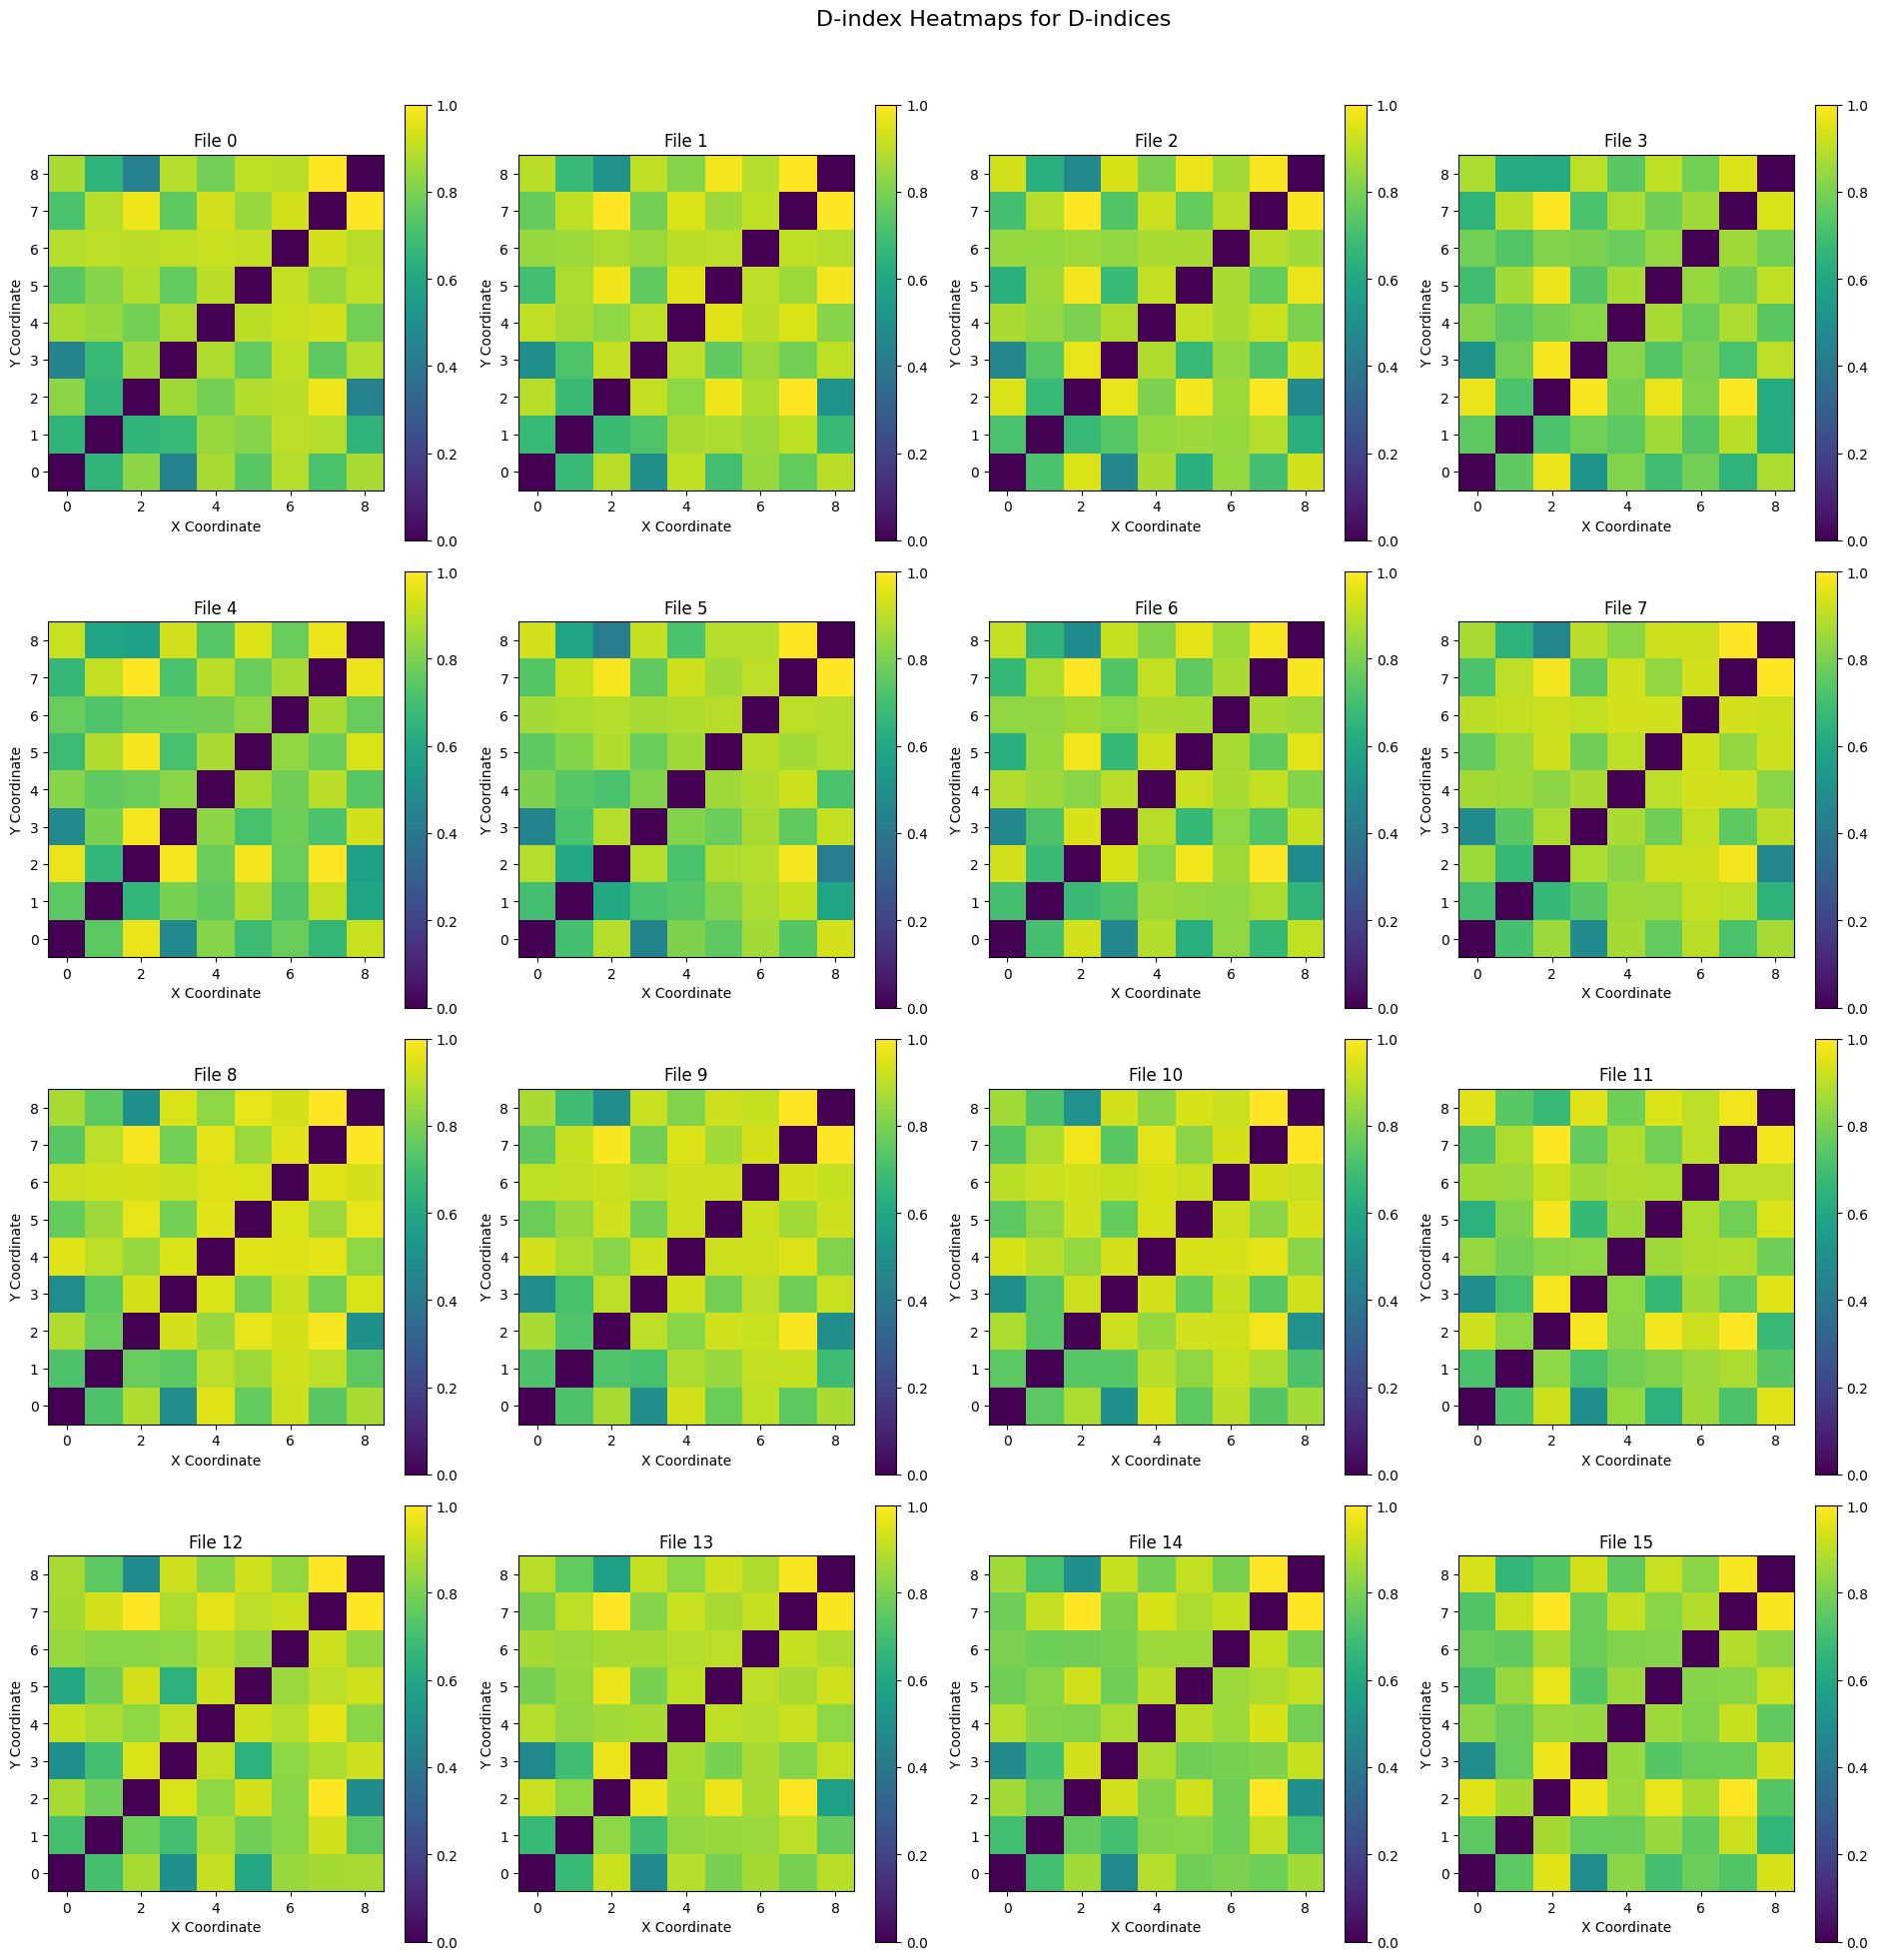

In [188]:
plot_d_index_heatmaps(d_indices)

In [132]:
def compute_d_index_duncan(data, grid_dimensions, range_by_type):
    X, Y = grid_dimensions
    num_types = 9
    type_count = np.zeros((X, Y, num_types))  # Counts for each type at each spatial unit
    D_matrices = [np.zeros((X, Y)) for _ in range(num_types)]  # 9 matrices for each type

    # Populate the 3D grid with agent counts
    for _, agent in data.iterrows():
        x, y, t = agent['x'], agent['y'], agent['type']
        type_count[x][y][t] += 1

    # Calculate the total number of agents for each type in the entire grid
    total_count_by_type = np.sum(type_count, axis=(0, 1))

    def wrap_index(index, dimension):
        """Wrap around the index for toroidal boundary conditions."""
        return index % dimension

    def compute_neighborhood_counts(x, y, r):
        """Compute counts of each type in the Von Neumann neighborhood of (x, y, z) with range r."""
        neighborhood_count = np.zeros(num_types)
        for dx in range(-r, r + 1):
            for dy in range(-r + abs(dx), r - abs(dx) + 1):
                    nx = wrap_index(x + dx, X)
                    ny = wrap_index(y + dy, Y)
                    neighborhood_count += type_count[nx][ny]
        return neighborhood_count

    # Calculate the Dissimilarity Index for each spatial unit
    for x in range(X):
        for y in range(Y):
            for t in range(num_types):
                r = range_by_type[t]
                neighborhood_count = compute_neighborhood_counts(x, y, r)
                
                for t_prime in range(num_types):
                    if total_count_by_type[t] > 0 and total_count_by_type[t_prime] > 0:
                        prop_t = neighborhood_count[t] / total_count_by_type[t]
                        prop_t_prime = neighborhood_count[t_prime] / total_count_by_type[t_prime]
                        
                        # Calculate the absolute difference
                        D = abs(prop_t - prop_t_prime)
                        
                        # Accumulate the difference in the respective matrix
                        D_matrices[t][x, y] += D

    # Normalize the D-index matrices
    for t in range(num_types):
        D_max = np.max(D_matrices[t])
        if D_max > 0:
            D_matrices[t] /= D_max  # Normalize to [0, 1]
        else:
            D_matrices[t] = np.zeros_like(D_matrices[t])  # Handle cases with no data

    return D_matrices

In [139]:
filenames = ['random_1', 'random_2', 'random_3', 'random_4', 'random_5', 'random_6', 'clustered_1', 'clustered_2', 'clustered_3', 'clustered_4', 'clustered_5', 'clustered_6']
path = "../blossom/hpc/outputs/"
rs = [1, 2, 3, 4, 5]
init_locs = ['R1', 'R1', 'R1', 'R1', 'R1', 'R1', 'C1', 'C1', 'C1', 'C1', 'C1', 'C1']
init_seed  = [0, 1, 2, 3, 4, 5, 0, 1, 2, 3, 4, 5]
# TBD
sample_times = [79, 91, 94, 129, 131, 82, 94, 76, 76, 79, 76, 120, 90, 105, 83, 132]
organism_group_labels = ["Bacteria", "Fungi", "Root-feeding Nematodes", "Bacterivorous Nematodes", "Fungivorous Nematodes", "Omnivorous Nematodes", "Fungivorous Mites", "Omnivorous Mites", "Collembolans"]

indices = pd.DataFrame(columns=['filename', 'init_locs', 'seed', 'type_id', '0', '1', '2', '3', '4', '5', '6', '7', '8'])

for idx, filename in enumerate(filenames):  
    df = pd.read_csv(path + filename + ".csv")
    data = df[df["tick"] == sample_times[idx]]
    data = data.reset_index(drop=True)
    d_index = compute_d_index_duncan(data, (400, 400),  [1,1,3,2,3,4,5,6,6])
    for type_id, row in enumerate(d_index):
        indices = pd.concat([indices, pd.DataFrame({'filename': [filename], 'init_locs': [init_locs[idx]], 'seed': [init_seed[idx]], 'type_id': [type_id], '0': [row[0]], '1': [row[1]], '2': [row[2]], '3': [row[3]], '4': [row[4]], '5': [row[5]], '6': [row[6]], '7': [row[7]], '8': [row[8]]})])

In [140]:
def plot_d_index_heatmaps(D_matrices):
    """
    Plot the D-index heatmaps for each agent type.
    
    Parameters:
    - D_matrices: List of 9 matrices, each representing the D-index heatmap for a specific type.
    """
    num_types = len(D_matrices)
    
    # Create a figure with 3x3 subplots
    fig, axes = plt.subplots(3, 3, figsize=(15, 15))
    
    # Flatten axes array for easy iteration
    axes = axes.flatten()
    
    # Plot each D-index matrix
    for t in range(num_types):
        ax = axes[t]
        cax = ax.imshow(D_matrices[t], cmap='viridis', origin='lower')
        ax.set_title(f'{organism_group_labels[t]}')
        ax.set_xlabel('X')
        ax.set_ylabel('Y')
        fig.colorbar(cax, ax=ax, orientation='vertical')
    
    plt.suptitle(f'D-index Heatmaps per Agent Type', fontsize=16)
    plt.tight_layout(rect=[0, 0, 0.95, 0.96])  # Adjust to make room for the suptitle
    plt.show()

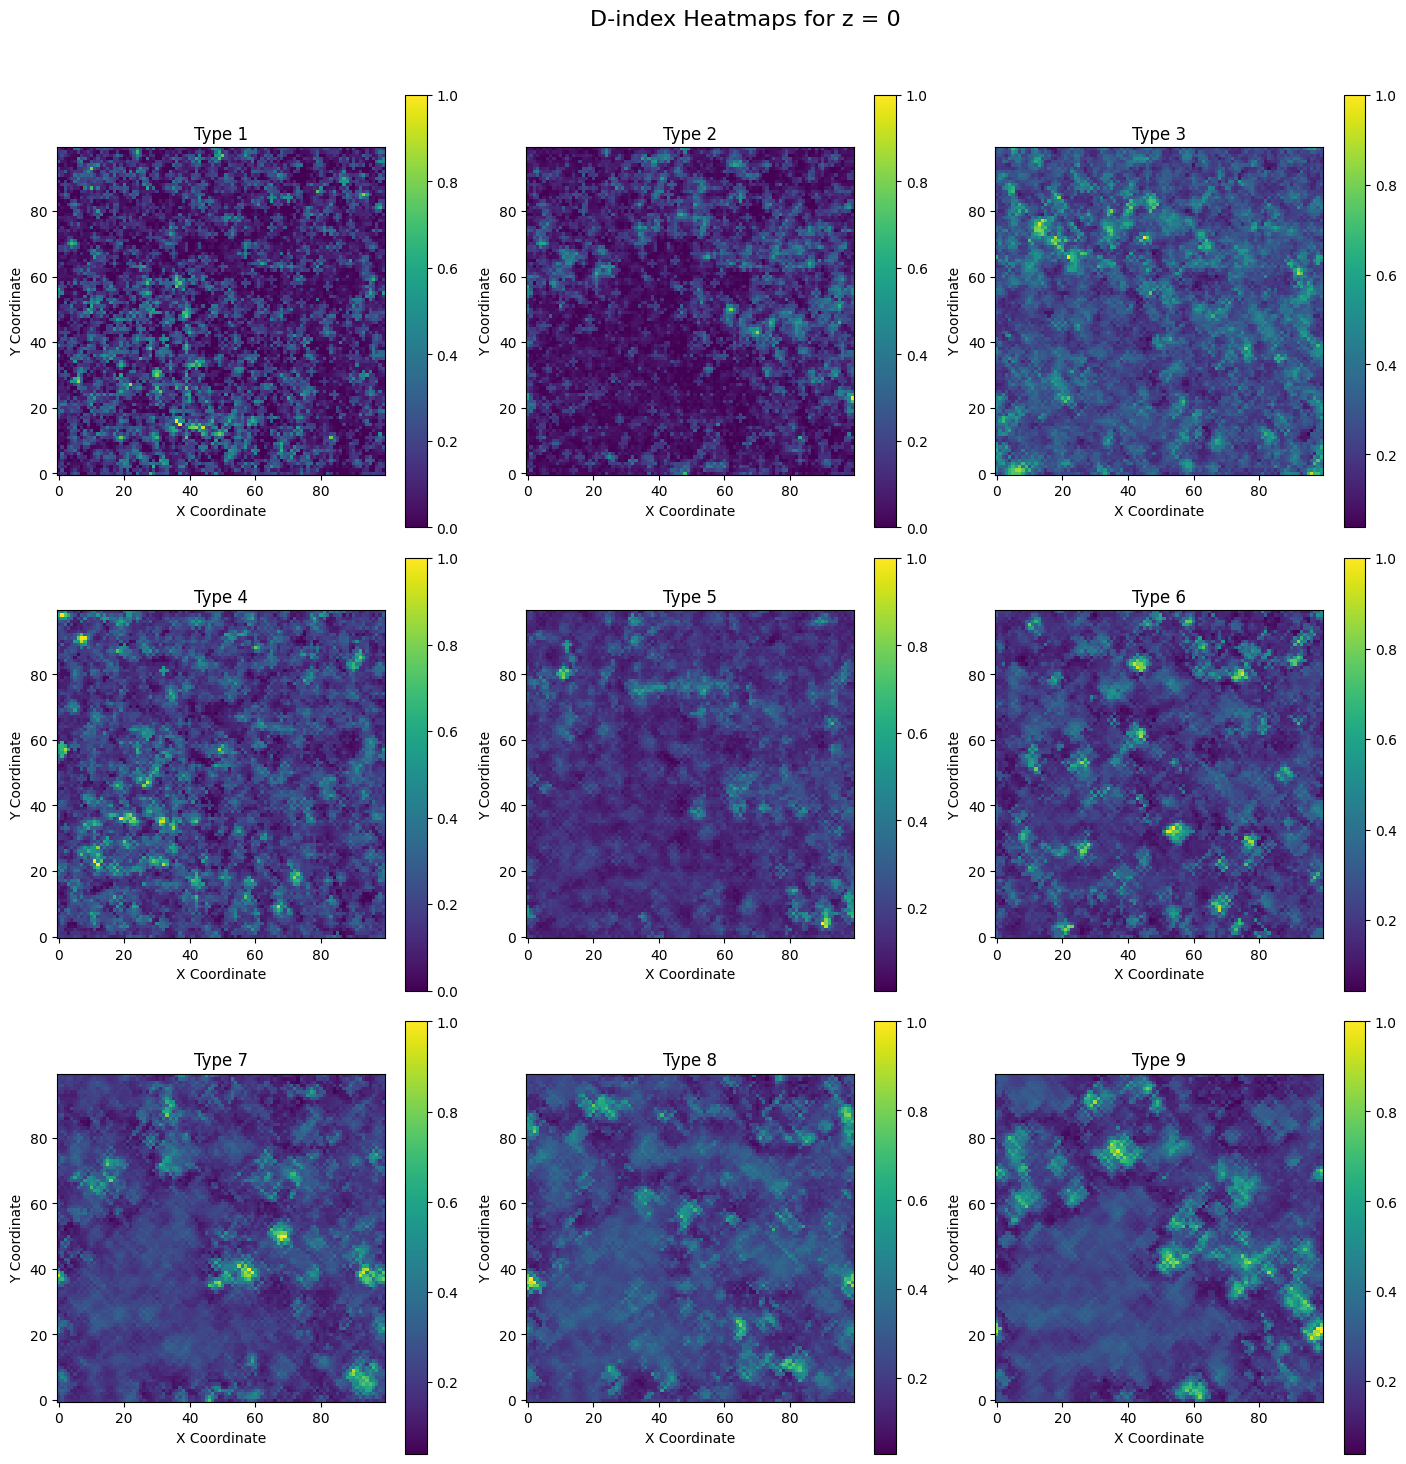

In [141]:
plot_d_index_heatmaps(d_index)